# Regression Model

In [73]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

df = pd.read_csv('out.csv')

In [74]:
import warnings
warnings.filterwarnings("ignore")

names = df[['last_name, first_name', 'on_base_plus_slg (2024)']]

df.drop(columns = ['player_id', 'last_name, first_name'], inplace=True)

X = df[['wobadiff (2023)', 'xslgdiff (2023)', 'xbadiff (2023)' , 'babipdiff (2023)', 'xhrdiff (2023)']]
y = df['ops_change 2023-2024']

steps = [('imputer', SimpleImputer()),
         ('scaler', StandardScaler()),
         ('ridge', Ridge())]

parameters = {'imputer__strategy': ['mean', 'median'],
              'ridge__alpha': [x for x in range(0, 100)]}

pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param_grid=parameters, cv=5)

clf.fit(X, y)

best_model = clf.best_estimator_.named_steps['ridge']

print(f"Best Parameters: {clf.best_params_}" 
      f"\nR: {clf.best_score_ ** 0.5}"
      f"\nR^2: {clf.best_score_}" 
      f"\nIntercept: {best_model.intercept_}")

values = {'Coefficients': best_model.coef_}
values_df = pd.DataFrame.from_dict(values, orient='index', columns=['wOBA-xwOBA', 'SLG-xSLG', 'BA-xBA', 'BABIP Diff', 'HR-xHR'])

display(values_df)

stats_2024 = df[['wobadiff (2024)', 'xslgdiff (2024)', 'xbadiff (2024)' , 'babipdiff (2024)', 'xhrdiff (2024)']]
stats_2024.fillna(value=stats_2024.mean(), inplace=True)
predictions = pd.DataFrame.join(names, pd.DataFrame(best_model.predict(stats_2024), columns=['% Change OPS']))
predictions['Predicted 2025 OPS'] = predictions['on_base_plus_slg (2024)'] * (1 + (predictions['% Change OPS'])/100)
predictions.rename(columns={'last_name, first_name' : 'Name', 'on_base_plus_slg (2024)': '2024 OPS'}, inplace=True)
predictions.sort_values(by=['Name'], inplace=True)
predictions.set_index('Name', inplace=True)

predictions.to_csv('predictions.csv')

Best Parameters: {'imputer__strategy': 'median', 'ridge__alpha': 70}
R: 0.429880304459788
R^2: 0.18479707616243998
Intercept: -1.9358895826735244e-16


,wOBA-xwOBA,SLG-xSLG,BA-xBA,BABIP Diff,HR-xHR
Coefficients,-1.640897,-1.166776,-1.501314,-1.205142,-1.527901


<Axes: xlabel='Predicted 2025 OPS', ylabel='Count'>

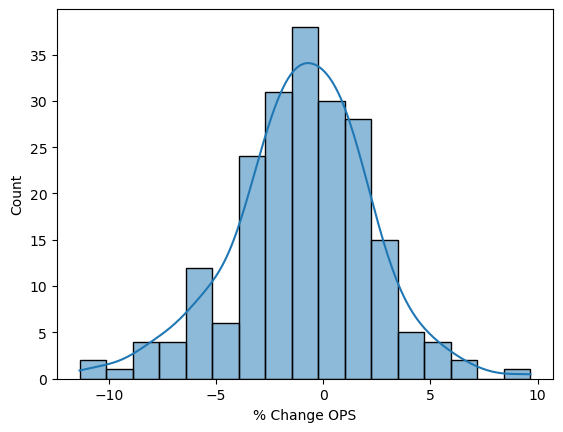

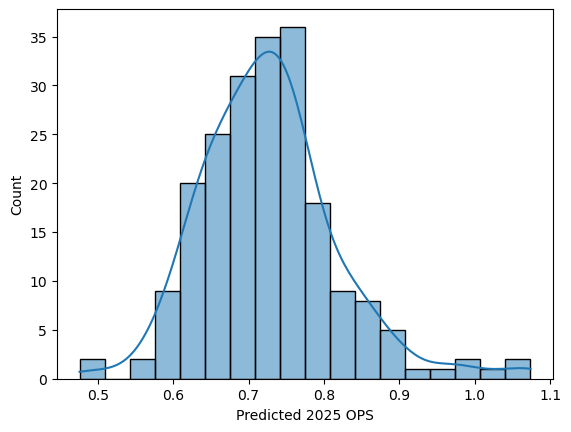

In [75]:
plt.figure()
sb.histplot(predictions['% Change OPS'], kde=True)

plt.figure()
sb.histplot(predictions['Predicted 2025 OPS'], kde=True)